# Summary: A/B-тест улучшенной рекомендательной модели

### Цель  
Проверить, улучшает ли новая рекомендательная модель (CatBoost + LightGCN + трансформерные признаки) пользовательскую вовлеченность по сравнению с текущей моделью (CatBoost + базовые признаки).

---

### Основная метрика:  
**Hitrate@5** — доля рекомендаций, получивших лайк в течение часа после показа.

| Группа      | Hitrate (по бакетам) |
|-------------|----------------------|
| Control     | 0.7067               |
| Test        | 0.7198               |
| **Δ (приращение)** | **+1.31 п.п.**         |
| **p-value (t-test)** | **7.4e-11**            |

 **Различие статистически значимо.**

---

### Дополнительные метрики:

#### 1. **Доля пользователей, поставивших хотя бы 1 лайк:**
- **Test:** 89.82%
- **Control:** 89.13%
- **Δ:** +0.69 п.п.
- **Z-test:** p = 0.0045 → **значимое различие**

#### 2. **Количество лайков на пользователя:**
- **Test:** 4.00  
- **Control:** 3.91   
- **Mann–Whitney U-тест:** p = 0.0017 → **значимое различие**

---

### Вывод:

Улучшенная модель рекомендаций **значимо повышает вовлеченность пользователей**:
- Hitrate вырос на **1.31 п.п.**
- **Больше пользователей** взаимодействуют с контентом
- **Общее число лайков на пользователя** также увеличилось

**Рекомендация:** запуск в продакшн и мониторинг устойчивости эффекта.


## Введение и гипотеза

**Цель**  
Проверить, приводит ли добавление новых признаков (features) из модели LightGCN и трансформера к улучшению качества рекомендательной системы по сравнению с текущей моделью на CatBoost с ручными фичами.

**Контрольная модель**  
Модель: CatBoost  
Фичи: ручные признаки пользователей и постов  
ROC-AUC: 0.77  
HitRate@5: 0.707  
STD (HitRate): 0.013  

**Тестовая модель**   
Модель: CatBoost  
Фичи: ручные + LightGCN эмбеддинги + трансформерные признаки  
ROC-AUC: 0.812  
Предполагаемый HitRate@5: 0.712  

**Основная гипотеза**

Добавление новых признаков в модель рекомендаций приведёт к статистически значимому увеличению метрики качества рекомендаций — HitRate@5 — с 0.707 до 0.712.

Нулевая гипотеза (H₀):
Нет различий в качестве рекомендаций между контрольной (без новых фичей) и тестовой (с новыми фичами) группами:
H₀: HitRate@5_test = HitRate@5_control

Альтернативная гипотеза (H₁):
Есть статистически значимые различия в качестве рекомендаций между группами:
H₁: HitRate@5_test ≠ HitRate@5_control

**Метрики**  
Основная метрика:
HitRate@5 – доля показов, в которых пользователь поставил лайк хотя бы одному из рекомендованных 5 постов.

Дополнительные метрики:
Доля пользователей, поставивших хотя бы один лайк

Среднее количество лайков на пользователя

**Ожидаемые бизнес-эффекты**  
Рост вовлеченности пользователей – больше взаимодействий с контентом (лайков), значит, пользователи проводят больше времени в продукте.

Повышение удовлетворённости от рекомендаций – более релевантные посты стимулируют лояльность.

### Дизайн эксперимента 
**Рандомизация**  
Пользователи были случайным образом распределены на контрольную и тестовую группы по user_id.
Чтобы исключить смещение и обеспечить стабильность, была использована детерминированная хеш-функция:

```python

import hashlib

def get_exp_group(user_id: int, salt: str = "experiment_1") -> str:
    key = f"{salt}_{user_id}"
    hash_val = hashlib.md5(key.encode()).hexdigest()
    num = int(hash_val[:8], 16) / 0xFFFFFFFF
    return "control" if num < 0.5 else "test"
```
Таким образом:

Пользователь с данным user_id всегда попадает в одну и ту же группу

Размер групп контролируется: по 50% в control и test



**Проверка SRM (Sample Ratio Mismatch)**  
Перед началом анализа провели SRM-тест — проверку, что количество пользователей в контрольной и тестовой группах соответствует ожидаемым пропорциям (50/50).
Для этого использовали χ²-критерий (хи-квадрат) на количество уникальных пользователей 


**Тест и мощность**

α (уровень значимости) = 0.05

MDE (минимально детектируемый эффект) = 0.005 

Baseline метрика (HitRate@5) = 0.707

Тестовая метрика (ожидаемая) = 0.712

Период: 2 недели

Пользователей в каждой группе = 30 000

Тест: бакетный t-test (есть зависимые показы одним и тем же пользователям)

Бакеты: 100 (т.е. анализ будет на агрегированных бакетах, не на уровне пользователей)  
→ 30 000 / 100 = 300 пользователей на бакет в среднем

Поскольку мы используем бакетный t-test, то рассчитываем мощность по разности средних двух выборок:  
Каждая точка — это hitrate в бакете (средняя доля лайков на бакет)  
Всего 100 точек на группу  

**Мощность теста: 0.772**


In [157]:
# расчет мощности

from statsmodels.stats.power import TTestIndPower

effect_size = (0.712 - 0.707) / 0.013  
alpha = 0.05
nobs = 100 

power_analysis = TTestIndPower()
power = power_analysis.power(effect_size=effect_size, nobs1=nobs, alpha=alpha, ratio=1.0)
print(f"Power: {power:.3f}")


Power: 0.772


## Проверка качества дизайна эксперимента (AA-тест) и выбор критерия
Перед запуском A/B-теста мы провели AA-тест на синтетических данных

Проверяем:

Уровень ложноположительных результатов (α) — должен быть близок к заявленному значению (0.05)

Мощность теста (1 − β) — насколько чувствителен эксперимент к ожидаемому приросту метрики

**Резюме раздела**:
- Альфа: 0.042, 95% ДИ: [0.030, 0.055]
- Мощность: 0.988, 95% ДИ: [0.981, 0.994]

In [142]:
N_USERS = 30_000          # Пользователей в каждой группе
N_BUCKETS = 100           # Бакеты
MDE = 0.005              # Минимально детектируемый эффект 
BASE_HITRATE = 0.707      # Базовый HitRate@5
N_EXPERIMENTS = 1000     # Кол-во симуляций теста
ALPHA = 0.05              # Уровень значимости

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import ttest_ind
import hashlib

def user_to_bucket(user_id, n_buckets=N_BUCKETS, salt="exp_01"):
    s = f"{user_id}_{salt}"
    h = hashlib.md5(s.encode('utf-8')).digest()
    h_int = int.from_bytes(h[:4], byteorder='big')
    return h_int % n_buckets

# генерируем синтетическую выборку
def simulate_user_buckets(hitrate=BASE_HITRATE, n_users=N_USERS, n_buckets=N_BUCKETS):
    user_ids = np.arange(n_users)
    
    buckets = [user_to_bucket(uid, n_buckets) for uid in user_ids]

    impressions = np.random.randint(1, 20, size=n_users)
    likes = np.random.binomial(impressions, hitrate)

    df = pd.DataFrame({
        'bucket': buckets,
        'impressions': impressions,
        'likes': likes
    })

    bucket_stats = df.groupby('bucket', as_index=False).agg({
        'likes': 'sum',
        'impressions': 'sum'
    })
    
    bucket_stats['hitrate'] = bucket_stats['likes'] / bucket_stats['impressions']
    
    return bucket_stats[['bucket', 'hitrate', 'impressions', 'likes']]



#  A/A тест
def run_aa_test(simulate_func, n_experiments=N_EXPERIMENTS, alpha=ALPHA):
    p_values = []

    for _ in range(n_experiments):
        sample1 = simulate_func(BASE_HITRATE, N_USERS, N_BUCKETS)
        sample2 = simulate_func(BASE_HITRATE, N_USERS, N_BUCKETS)
        
        x1 = sample1['hitrate'].values
        x2 = sample2['hitrate'].values
        
        _, p = ttest_ind(x1, x2, equal_var=False)
        p_values.append(p)

    p_values = np.array(p_values)
    alpha_error = (p_values < alpha).mean()

    # Доверительный интервал для alpha
    ci = stats.binom.interval(0.95, n_experiments, alpha_error, loc=0)
    ci = np.array(ci) / n_experiments

    # Гистограмма p-value
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(p_values, bins=50, edgecolor='black')
    plt.axvline(alpha, color='red', linestyle='--', label=f'alpha = {alpha}')
    plt.title('Гистограмма p-value в A/A тесте')
    plt.xlabel('p-value')
    plt.ylabel('Количество экспериментов')
    plt.legend()

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(p_values, dist="uniform", plot=plt)
    plt.title('Q-Q plot p-value')
    plt.tight_layout()
    plt.show()

    return alpha_error, ci


# A/B тест (расчёт мощности)
def run_ab_test(simulate_func, mde=MDE, n_experiments=N_EXPERIMENTS, alpha=ALPHA):
    p_values = []

    for _ in range(n_experiments):
        control_sample = simulate_func(BASE_HITRATE, N_USERS, N_BUCKETS)
        test_sample = simulate_func(BASE_HITRATE + mde, N_USERS, N_BUCKETS)

        control_values = control_sample['hitrate'].values
        test_values = test_sample['hitrate'].values

        _, p = ttest_ind(test_values, control_values, equal_var=False)
        p_values.append(p)

    p_values = np.array(p_values)
    power = (p_values < alpha).mean()

    ci = stats.binom.interval(0.95, n_experiments, power, loc=0)
    ci = np.array(ci) / n_experiments

    return power, ci



=== A/A тест ===


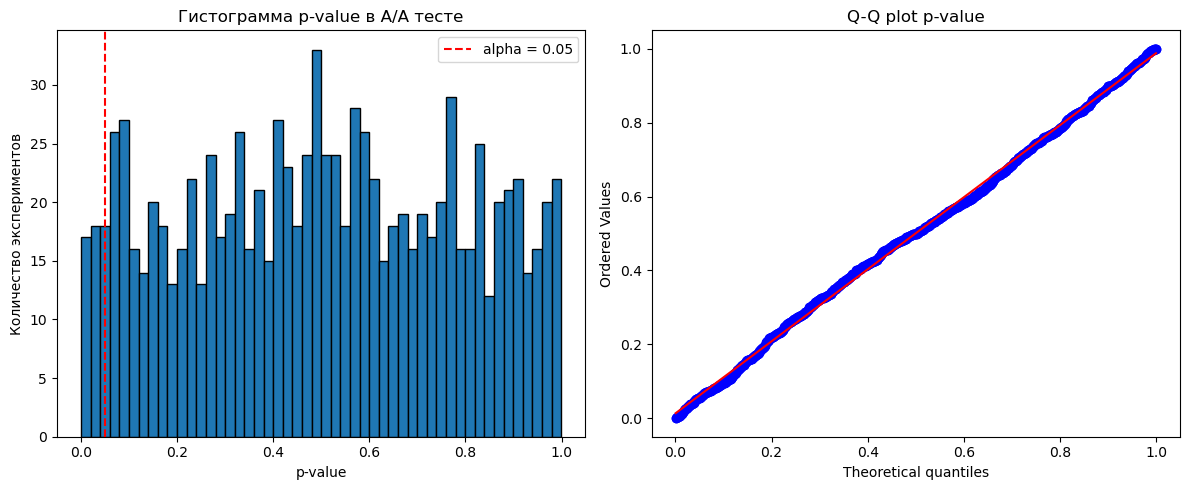

Альфа: 0.042, 95% ДИ: [0.030, 0.055]

=== A/B тест ===
Мощность: 0.988, 95% ДИ: [0.981, 0.994]


In [155]:

print("=== A/A тест ===")
alpha_err, ci_alpha = run_aa_test(simulate_user_buckets)
print(f"Альфа: {alpha_err:.3f}, 95% ДИ: [{ci_alpha[0]:.3f}, {ci_alpha[1]:.3f}]")


print("\n=== A/B тест ===")
power, ci_power = run_ab_test(simulate_user_buckets)
print(f"Мощность: {power:.3f}, 95% ДИ: [{ci_power[0]:.3f}, {ci_power[1]:.3f}]")



## Анализ результатов теста

### Проверка корректности рандомизации (SRM-check)
1. Удаление пользователей, попавших в обе группы
Перед анализом необходимо убедиться, что каждый пользователь попал только в одну экспериментальную группу. Иначе результаты теста могут быть искажены.
2. Проверка SRM (Sample Ratio Mismatch)

**Резюме раздела**:
- Пользователи, попавшие в обе группы, обнаружены (4 пользователя) и исключены.
- Распределение по группам соответствует ожиданиям (SRM не нарушен, p-value: 0.395).
- Тест можно считать корректно рандомизированным.

In [74]:
recommendations = pd.read_csv('views.csv')
print(recommendations.shape, recommendations.head())

(193295, 4)    user_id exp_group             recommendations   timestamp
0   128381   control  [3644 4529 4704 5294 4808]  1654030803
1   146885      test  [1399 1076  797 7015 5942]  1654030811
2    50948      test  [2315 3037 1861 6567 4093]  1654030825
3    37703      test  [2842 1949  162 1588 6794]  1654030826
4    14661      test  [2395 5881 5648 3417  673]  1654030829


In [75]:
likes = pd.read_csv('likes.csv')
print(likes.shape, likes.head())

(230176, 3)    user_id  post_id   timestamp
0   128381     4704  1654030804
1   146885     1399  1654030816
2    50948     2315  1654030828
3    14661      673  1654030831
4    37703     1588  1654030833


In [76]:
# Найдём user_id, которые встречаются в более чем одной группе

multi_group_users = (
    recommendations.groupby('user_id', as_index=False)['exp_group']
    .nunique()
    .query("exp_group > 1")
)

print(multi_group_users)


       user_id  exp_group
10071    25623          2
20633    55788          2
54475   142283          2
57065   148670          2


In [77]:
recommendations = recommendations[~recommendations['user_id'].isin(multi_group_users)]

In [78]:
recommendations.groupby('exp_group').user_id.nunique()

exp_group
control    32354
test       32663
Name: user_id, dtype: int64

In [79]:
# Проверка деления на группы SRM

from scipy.stats import chi2_contingency

observed = recommendations.groupby('exp_group').user_id.nunique().to_list()

total = sum(observed)
expected = [total / 2, total / 2]

# χ² тест
chi2, p_value, _, _ = chi2_contingency([observed, expected])

print("p-value:", p_value)


p-value: 0.3945716916463896


## Анализ дополнительных метрик
**Доля пользователей, поставивших хотя бы один лайк**

share_test = 0.8982    
share_control = 0.8913 

*z-тест для пропорций:*  

Z-stat: 2.844  
P-value: 0.0045  

Вывод: Различие между группами статистически значимо на уровне значимости 0.05. Это означает, что в тестовой группе больше пользователей проявили активность (поставили хотя бы один лайк)

**Количество лайков на одного пользователя**

likes_test = 4  
likes_control = 3.91

Распределения лайков на пользователя в обеих группах оказались асимметричными, с выраженным правым хвостом.
Даже после логарифмического преобразования (log(1 + x)) данные не соответствуют нормальному распределению по Shapiro–Wilk тесту (p-value < 0.05):

Shapiro test (log likes):
Control group: p ≈ 0.0000
Test group:    p ≈ 0.0000


*Mann–Whitney U-тест:*

stat: 429294691   
P-value: 0.0017

Вывод: Различие статистически значимо на уровне значимости 0.05, что указывает на большее число лайков на пользователя в тестовой группе.

In [80]:
# посчитаем скольк пользователей попали в аб тест, сколько их них лайкали посты

users_ab_count = recommendations.user_id.nunique()

In [81]:
users = recommendations.user_id.unique()
users_likes_count = likes[likes.user_id.isin(users)].user_id.nunique()
users_likes_count/users_ab_count

0.8947595096365343

In [82]:
# Доля пользователей с хотя бы 1 лайком
users_test = recommendations[recommendations['exp_group'] == 'test'].user_id.unique()
users_control = recommendations[recommendations['exp_group'] == 'control'].user_id.unique()

users_likes_test = likes[likes.user_id.isin(users_test)].user_id.nunique()
users_likes_control = likes[likes.user_id.isin(users_control)].user_id.nunique()

share_test = users_likes_test / len(users_test) if len(users_test) > 0 else 0
share_control = users_likes_control / len(users_control) if len(users_control) > 0 else 0

print(f"Test group: {share_test:.4f}, Control group: {share_control:.4f}")


Test group: 0.8982, Control group: 0.8913


In [83]:
# z-тест для пропорций 

from statsmodels.stats.proportion import proportions_ztest

# Число пользователей с хотя бы одним лайком
successes = [users_likes_test, users_likes_control]

# Общее число пользователей в каждой группе
n_obs = [len(users_test), len(users_control)]

# z-тест
z_stat, p_val = proportions_ztest(count=successes, nobs=n_obs)

print(f"Z-stat: {z_stat:.3f}")
print(f"P-value: {p_val:.4f}")

if p_val < 0.05:
    print("❗ Различие статистически значимо.")
else:
    print("✅ Нет статистически значимого различия.")


Z-stat: 2.844
P-value: 0.0045
❗ Различие статистически значимо.


In [84]:
# Число лайков на пользователя
likes_per_user_test = likes[likes.user_id.isin(users_test)] \
    .groupby('user_id', as_index=False) \
    .agg(likes_count=('post_id', 'count'))

likes_per_user_control = likes[likes.user_id.isin(users_control)] \
    .groupby('user_id', as_index=False) \
    .agg(likes_count=('post_id', 'count'))


/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


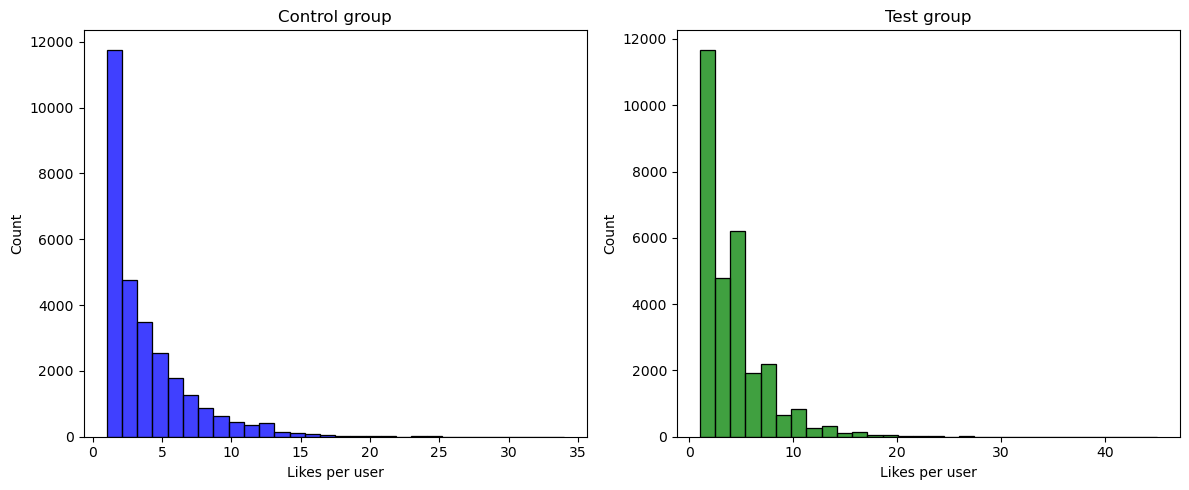

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Control
plt.subplot(1, 2, 1)
sns.histplot(likes_per_user_control['likes_count'], bins=30, kde=False, color='blue')
plt.title('Control group')
plt.xlabel('Likes per user')
plt.ylabel('Count')

# Test
plt.subplot(1, 2, 2)
sns.histplot(likes_per_user_test['likes_count'], bins=30, kde=False, color='green')
plt.title('Test group')
plt.xlabel('Likes per user')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [86]:
likes_per_user_test.likes_count.describe()

count    29337.000000
mean         4.000716
std          3.256923
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         45.000000
Name: likes_count, dtype: float64

In [87]:
likes_per_user_control.likes_count.describe()

count    28838.000000
mean         3.913101
std          3.139696
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         34.000000
Name: likes_count, dtype: float64

/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/irinanechetnaya/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


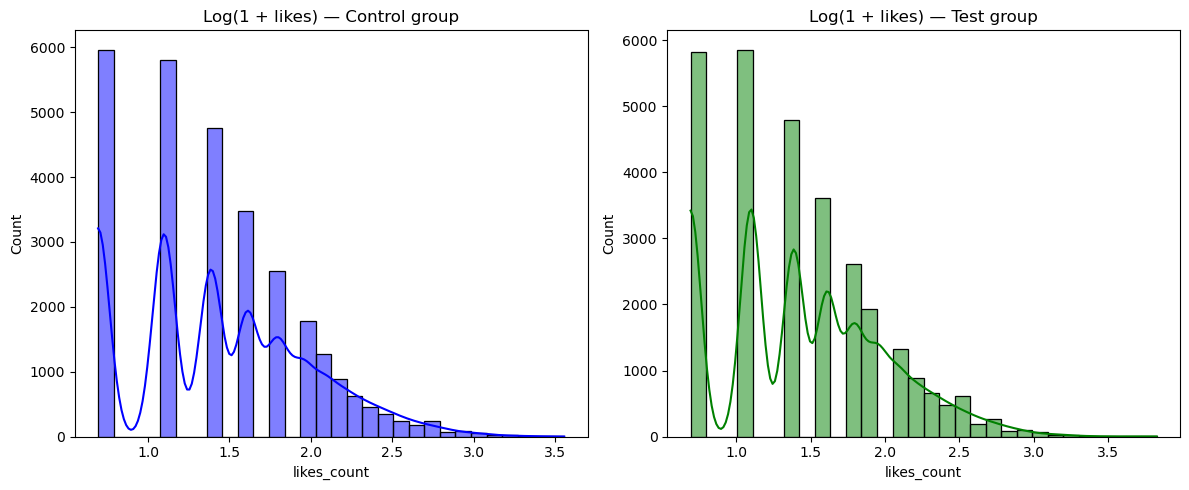

((0.9422689015978568, 2.0477617370933456e-40),
 (0.940141313103289, 5.748076577111812e-41))

In [88]:
#Log-преобразование и t-test

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro


log_test = np.log1p(likes_per_user_test['likes_count'])
log_control = np.log1p(likes_per_user_control['likes_count'])

shapiro_test_stat, shapiro_test_p = shapiro(log_test.sample(5000, random_state=42))
shapiro_control_stat, shapiro_control_p = shapiro(log_control.sample(5000, random_state=42))


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(log_control, bins=30, color='blue', kde=True)
plt.title("Log(1 + likes) — Control group")

plt.subplot(1, 2, 2)
sns.histplot(log_test, bins=30, color='green', kde=True)
plt.title("Log(1 + likes) — Test group")

plt.tight_layout()
plt.show()

(shapiro_test_stat, shapiro_test_p), (shapiro_control_stat, shapiro_control_p)


In [89]:
# Mann–Whitney U-тест — сравнение медиан
from scipy.stats import mannwhitneyu

stat, p = mannwhitneyu(
    likes_per_user_test['likes_count'],
    likes_per_user_control['likes_count'],
    alternative='two-sided'
)

print(f"Mann–Whitney U test: stat={stat:.2f}, p={p:.4f}")


Mann–Whitney U test: stat=429294691.00, p=0.0017


## Расчёт основной метрики: HitRate@5
**Цель:**
Соотнести отображённые пользователю рекомендации с последующими лайками и вычислить долю показов, завершившихся хотя бы одним лайком — HitRate@5.

**Подготовка данных:**
Нумерация показов:
Каждой записи с рекомендациями был присвоен уникальный show_number на основе позиции в датафрейме (recommendations.index).

Разворачивание списка рекомендаций:
Каждая пятёрка постов (из recommendations) была преобразована в отдельные строки, по одной рекомендации на строку — через .explode().

**Соединение с лайками:**
Таблица была соединена с лайками по user_id и post_id, чтобы найти совпадения.

**Фильтрация по времени:**
Считаем лайком только те действия, которые:
- произошли после показа (timestamp_like >= timestamp_view);
- произошли в течение часа после показа (< 1 час).

**Агрегация:**
Для каждого user_id и show_number агрегируем поле is_like и сохраняем максимум (1, если был хотя бы один лайк на 5 рекомендаций).

HitRate@5 (Test)    = 0.7198  
HitRate@5 (Control) = 0.7066



In [90]:
recommendations.dtypes

user_id             int64
exp_group          object
recommendations    object
timestamp           int64
dtype: object

In [91]:
recommendations['show_number'] = recommendations.index
recommendations['recommendations'] = recommendations['recommendations'].apply(
    lambda x: list(map(int, x.strip('[]').split()))
)
recommendations_exploded = recommendations.explode('recommendations').reset_index(drop=True)
recommendations_exploded['timestamp'] = pd.to_datetime(recommendations_exploded['timestamp'], unit='s')
recommendations_exploded = recommendations_exploded.rename(columns={'recommendations': 'post_id', 'timestamp': 'timestamp_view'})

likes = likes.rename(columns={'timestamp': 'timestamp_like'})

In [92]:
views_likes = recommendations_exploded.merge(likes, how='left', on = ['user_id', 'post_id'])

In [93]:
views_likes['timestamp_like'] = pd.to_datetime(views_likes['timestamp_like'], unit='s')
views_likes['time_before_like'] = views_likes['timestamp_like'] - views_likes['timestamp_view']
views_likes.head()

,user_id,exp_group,post_id,timestamp_view,show_number,timestamp_like,time_before_like
0,128381,control,3644,2022-05-31 21:00:03,0,NaT,NaT
1,128381,control,4529,2022-05-31 21:00:03,0,NaT,NaT
2,128381,control,4704,2022-05-31 21:00:03,0,2022-05-31 21:00:04,0 days 00:00:01
3,128381,control,5294,2022-05-31 21:00:03,0,2022-05-31 21:00:38,0 days 00:00:35
4,128381,control,4808,2022-05-31 21:00:03,0,NaT,NaT


In [94]:
views_likes['is_like'] = (
    (views_likes['time_before_like'] >= pd.Timedelta(0)) &
    (views_likes['time_before_like'] < pd.Timedelta(hours=1))
).astype(int)
views_likes.head()

,user_id,exp_group,post_id,timestamp_view,show_number,timestamp_like,time_before_like,is_like
0,128381,control,3644,2022-05-31 21:00:03,0,NaT,NaT,0
1,128381,control,4529,2022-05-31 21:00:03,0,NaT,NaT,0
2,128381,control,4704,2022-05-31 21:00:03,0,2022-05-31 21:00:04,0 days 00:00:01,1
3,128381,control,5294,2022-05-31 21:00:03,0,2022-05-31 21:00:38,0 days 00:00:35,1
4,128381,control,4808,2022-05-31 21:00:03,0,NaT,NaT,0


In [95]:
exp_likes = views_likes.groupby(
    ['user_id', 'exp_group', 'timestamp_view', 'show_number'], as_index=False
).agg(has_like=('is_like', 'max'))


In [43]:
hitrate_test = exp_likes[exp_likes.exp_group == 'test'].has_like.sum() / exp_likes[exp_likes.exp_group == 'test'].has_like.count()
hitrate_control = exp_likes[exp_likes.exp_group == 'control'].has_like.sum() / exp_likes[exp_likes.exp_group == 'control'].has_like.count()

print(hitrate_test, hitrate_control)

0.7198427520455648 0.7066550457573305


In [44]:
exp_likes.shape == recommendations.shape

True

In [45]:
exp_likes.shape

(193295, 5)

## Бакетный анализ и сравнение hitrate

Мы применили бакетизацию по show_number — уникальному идентификатору показа рекомендаций.   
Каждую группу (control и test) мы разделили на 100 бакетов, а затем рассчитали среднее значение hitrate в каждом бакете.  

Затем был применён t-тест (ttest_ind с equal_var=False) для сравнения средних hitrate по бакетам 
в тестовой и контрольной группе.

**Результаты**  
Средний hitrate по бакетам:

Test: 0.7198

Control: 0.7067

Разница: +1.31 п.п. в пользу тестовой группы

T-статистика: 6.8532

P-значение: 9.1e-11

**Вывод**  
Результаты t-теста показывают, что разница между группами статистически значима (p-value ≪ 0.05). Это подтверждает, что добавление новых признаков (фичей из трансформера и LightGCN) в рекомендательную модель привело к улучшению качества рекомендаций по основной метрике — hitrate@5.

Разница в +1.31 п.п. больше ожидаемого прироста по гипотезе (MDE = 0.5 п.п.) 

In [110]:
import hashlib
N_BUCKETS = 100

def user_to_bucket(user_id, n_buckets=N_BUCKETS, salt="my_salt"):
    s = f"{user_id}_{salt}"
    h = hashlib.md5(s.encode('utf-8')).digest()
    h_int = int.from_bytes(h[:4], byteorder='big')
    return h_int % n_buckets

exp_likes['bucket'] = exp_likes['user_id'].apply(lambda uid: user_to_bucket(uid))


bucket_stats = exp_likes.groupby(['exp_group', 'bucket'], as_index=False).agg(
    likes=('has_like', 'sum'),
    impressions=('has_like', 'count')
)
bucket_stats['hitrate'] = bucket_stats['likes'] / bucket_stats['impressions']

hitrate_test_avg = bucket_stats[bucket_stats.exp_group == 'test']['hitrate'].mean()
hitrate_control_avg = bucket_stats[bucket_stats.exp_group == 'control']['hitrate'].mean()

print(f"Средний hitrate по бакетам:\nTest: {hitrate_test_avg:.4f}\nControl: {hitrate_control_avg:.4f}")

Средний hitrate по бакетам:
Test: 0.7196
Control: 0.7063


In [111]:
from scipy.stats import ttest_ind

test_buckets = bucket_stats[bucket_stats.exp_group == 'test']['hitrate']
control_buckets = bucket_stats[bucket_stats.exp_group == 'control']['hitrate']

t_stat, p_value = ttest_ind(test_buckets, control_buckets, equal_var=False)

print(f"T-статистика: {t_stat:.4f}")
print(f"P-значение: {p_value:.20f}")



T-статистика: 5.5955
P-значение: 0.00000007442140542968
